In [1]:
from pandas import DataFrame, read_csv
import pandas as pd #this is how I usually import pandas
import matplotlib.pyplot as plt #for plot
import nltk
#read_csv?
Location = r'../twitter_data/train2017.tsv'
df = pd.read_csv(Location,delimiter = '\t',names=['id','id2','tag','text'])
# df.text

Location_test = r'../twitter_data/test2017.tsv'
df_test = pd.read_csv(Location_test,delimiter = '\t',names=['id','id2','tag','text'])


Location_corects = r'../twitter_data/SemEval2017_task4_subtaskA_test_english_gold.txt'
df_corects = pd.read_csv(Location_corects,delimiter = '\t',names=['id','tag'])

In [2]:
from bs4 import BeautifulSoup
import re
from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import StemmerI, RegexpStemmer, LancasterStemmer, ISRIStemmer, PorterStemmer, SnowballStemmer, RSLPStemmer
from string import punctuation
from nltk.stem import  WordNetLemmatizer
from nltk.corpus import wordnet

def get_wordnet_pos(word):
    """Map POS tag to first character lemmatize() accepts"""
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}

    return tag_dict.get(tag, wordnet.NOUN)

lemmatizer = WordNetLemmatizer()

stemmer = PorterStemmer()

tweets = df.text.tolist()

In [3]:
import nltk

# stopwords = set(stopwords.words('english'))

def clean_text(tweet):
    tweet = tweet.lower() 
    tweet = BeautifulSoup(tweet,'lxml').get_text() 
    tweet = re.sub(r"@\w+", "",tweet) # Remove twitter handle
    tweet = re.sub(r"\d", "",tweet)   # Remove numbers 
    tweet = re.sub(r"_+", "",tweet)   # Remove consecutive underscores
    tweet = re.sub('www.?[A-Za-z0-9./]+','',tweet)
    tweet = re.sub('http?[A-Za-z0-9./]+','',tweet)
    tweet = re.sub("[^a-zA-Z]", " ", tweet)
    #tweet=tweet.strip(punctuation)
    tokens = word_tokenize(tweet)
    stems = [  stemmer.stem(token) for token in tokens ]
    lemms = [lemmatizer.lemmatize(w, get_wordnet_pos(w)) for w in stems]
    filtered = [w for w in lemms if not w in stopwords.words('english')]
    tweet = ' '.join(filtered)
    return tweet

clean_tweets = df.text.apply(clean_text)

# print(clean_tweets)

In [72]:
# Start with loading all necessary libraries
import numpy as np
import pandas as pd
from os import path
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

import matplotlib.pyplot as plt



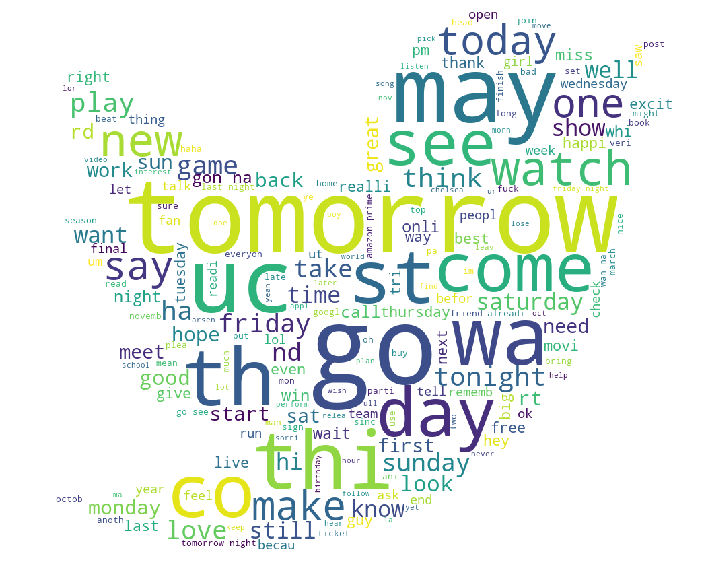

In [5]:
import imageio
from scipy.misc import imread

twitter_mask = imageio.imread('./twitter_mask.png')


wordcloud = WordCloud(
                      background_color='white',
                      width=1800,
                      height=1400,
                      mask=twitter_mask).generate(clean_tweets.to_string())
plt.figure( figsize=(20,10) )
plt.imshow(wordcloud)
plt.axis("off")
plt.savefig('./my_twitter_wordcloud_2.png', dpi=300)
plt.show()

In [6]:
clean_tweets_test = df_test.text.apply(clean_text)


In [150]:
def lexica(text):
    Location_affin = r'../lexica/generic/generic.txt'
    mydict = {}
    with open(Location_affin) as f:
        for line in f:
            if len(line.split()) == 2:
                (key,value) = line.split()
                mydict[key] = value


    import random
    metadata = []
    for tweet in text:
        arr = []
        tmp = []
        tmp.append(len(tweet.split()))
        for word in tweet.split():
            if word in mydict:
                arr.append(float(mydict[word]))
        if arr:
            tmp.append(min(arr)) 
            if min(arr) == max(arr):
                ran = random.randint(-3,3)
                tmp.append(ran)
                tmp.append(((ran+min(arr))/ 2))  
            else:
                tmp.append(max(arr))  
                tmp.append(float(sum(arr) / len(arr)))  
        else:
            ran1 = random.randint(-3,3)
            ran2 = random.randint(-3,3)
            tmp.append(ran1)
            tmp.append(ran2)
            tmp.append(((ran1+ran2) / 2))  

        metadata.append(tmp)
    return metadata



In [23]:
from sklearn.feature_extraction.text import CountVectorizer
import sys
import numpy

numpy.set_printoptions(threshold=sys.maxsize)
bow_vectorizer = CountVectorizer( max_df=1.0,min_df=1,max_features=300, stop_words='english') 
bow_xtrain = bow_vectorizer.fit_transform(clean_tweets)  #TWEETS : a list with the actual tweets 

bow_xtest = bow_vectorizer.fit_transform(clean_tweets_test)  #TWEETS : a list with the actual tweets 

In [24]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=3)


In [25]:
X = bow_xtrain.toarray()
Y = df.tag
knn.fit(X , Y)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=3, p=2,
           weights='uniform')

In [26]:
result = knn.predict(bow_xtest.toarray())
from sklearn import metrics
print(metrics.accuracy_score(result, df_corects.tag))

0.3968577010745685


In [151]:
metadata = lexica(df.text)
arr_train = []
arr_test = []
for vect in zip(bow_xtrain.toarray(),np.array(metadata)): 
    arr_train.append(np.append(vect[0],vect[1]))
for vect in zip(bow_xtest.toarray(),np.array(metadata)): 
    arr_test.append(np.append(vect[0],vect[1]))

In [152]:
knn.fit(arr_train , Y)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=3, p=2,
           weights='uniform')

In [153]:
result = knn.predict(arr_test)
from sklearn import metrics
print(metrics.accuracy_score(result, df_corects.tag))

0.38692608270921525
